In [130]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd

plt.style.use(hep.style.ROOT)

### user defined

In [136]:
### Variables used in software
baseline = 0
#16/12/2022 14:10
import time
#help(time)
starttime=time.struct_time((2022, 12, 16, 14, 10,0,-1,-1,-1))

renameChannels=False

In [213]:
with open('Run12_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
din={"timestamp":[], "trigID":[]}
#din.update({f"timestamp_{unit}":[] for unit in "year month day hour minute"})
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue
    split = line.split()
    
    if len(split)== 6:
        timestamp_us=float(split[0])
        din['timestamp'].append(timestamp_us)
        trigID=int(split[1])
        din['trigID'].append(trigID)
    
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG)-baseline)
    din[f"Ch_{channel}_HG"].append(float(HG)-baseline)
df = pd.DataFrame(din)


if renameChannels:
    new_channels=[]
    for ch in reversed(channels):
        newname=str(int(ch)+1)
        if len(newname)==1:
            newname="0"+newname
        df = df.rename({f"Ch_{ch}_LG":f"Ch_{newname}_LG", f"Ch_{ch}_HG":f"Ch_{newname}_HG"}, axis=1)
        new_channels.append(newname)
    channels=list(reversed(new_channels))
    

print(f"Done! Total events: {len(df)}")
print(f"channels in df are:  {channels}")
#channels.remove("00")

Done! Total events: 6544
channels in df are:  ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']


In [214]:
def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def LandauPlusGauss(x, normalization,location,stdev, a, mu, sigma):
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)+a*np.exp(-(x-mu)**2/(2*sigma**2))

def Gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

27.397158424010325
24.791673789816386
27.520575909562513
25.063961409606797
32.695786575376296
31.077116858723592
30.696001368765977
26.10133715202035
26.941892367111965
23.56783330385466
29.10974739320618
24.883350705544917
28.349743907101022
24.516017848176173
31.171762836090828
0
0.5


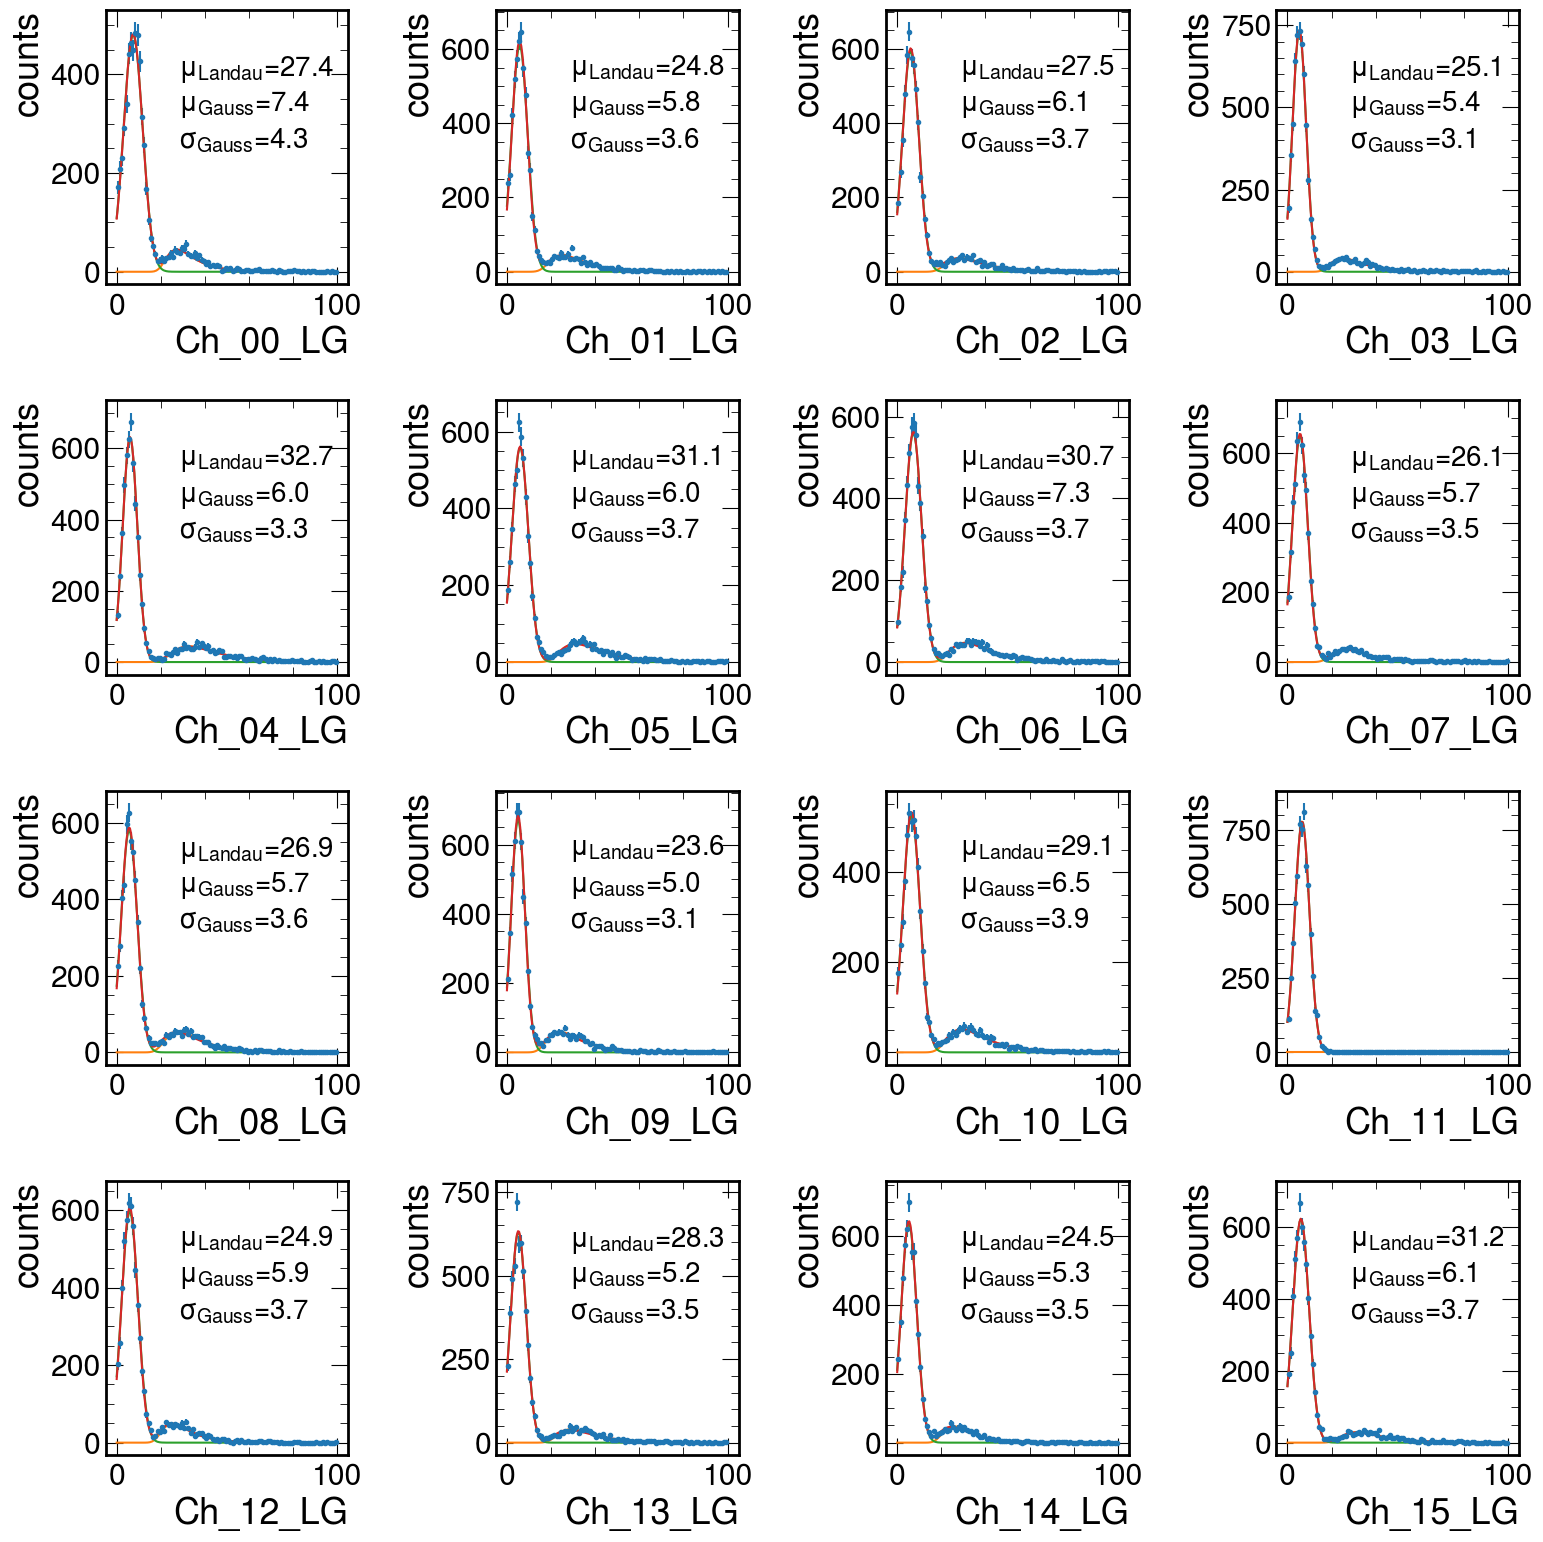

494.8157678513621
477.1880659348812
571.928201150584
551.4693058876094
703.6605434338649
652.6171925700355
644.9502300675828
534.0796168600365
556.4673363244124
510.44698150503024
588.1718416181916
490.8634806457687
660.9028705074182
523.0056020340952
659.5169413784498
0
3.3333333333333335


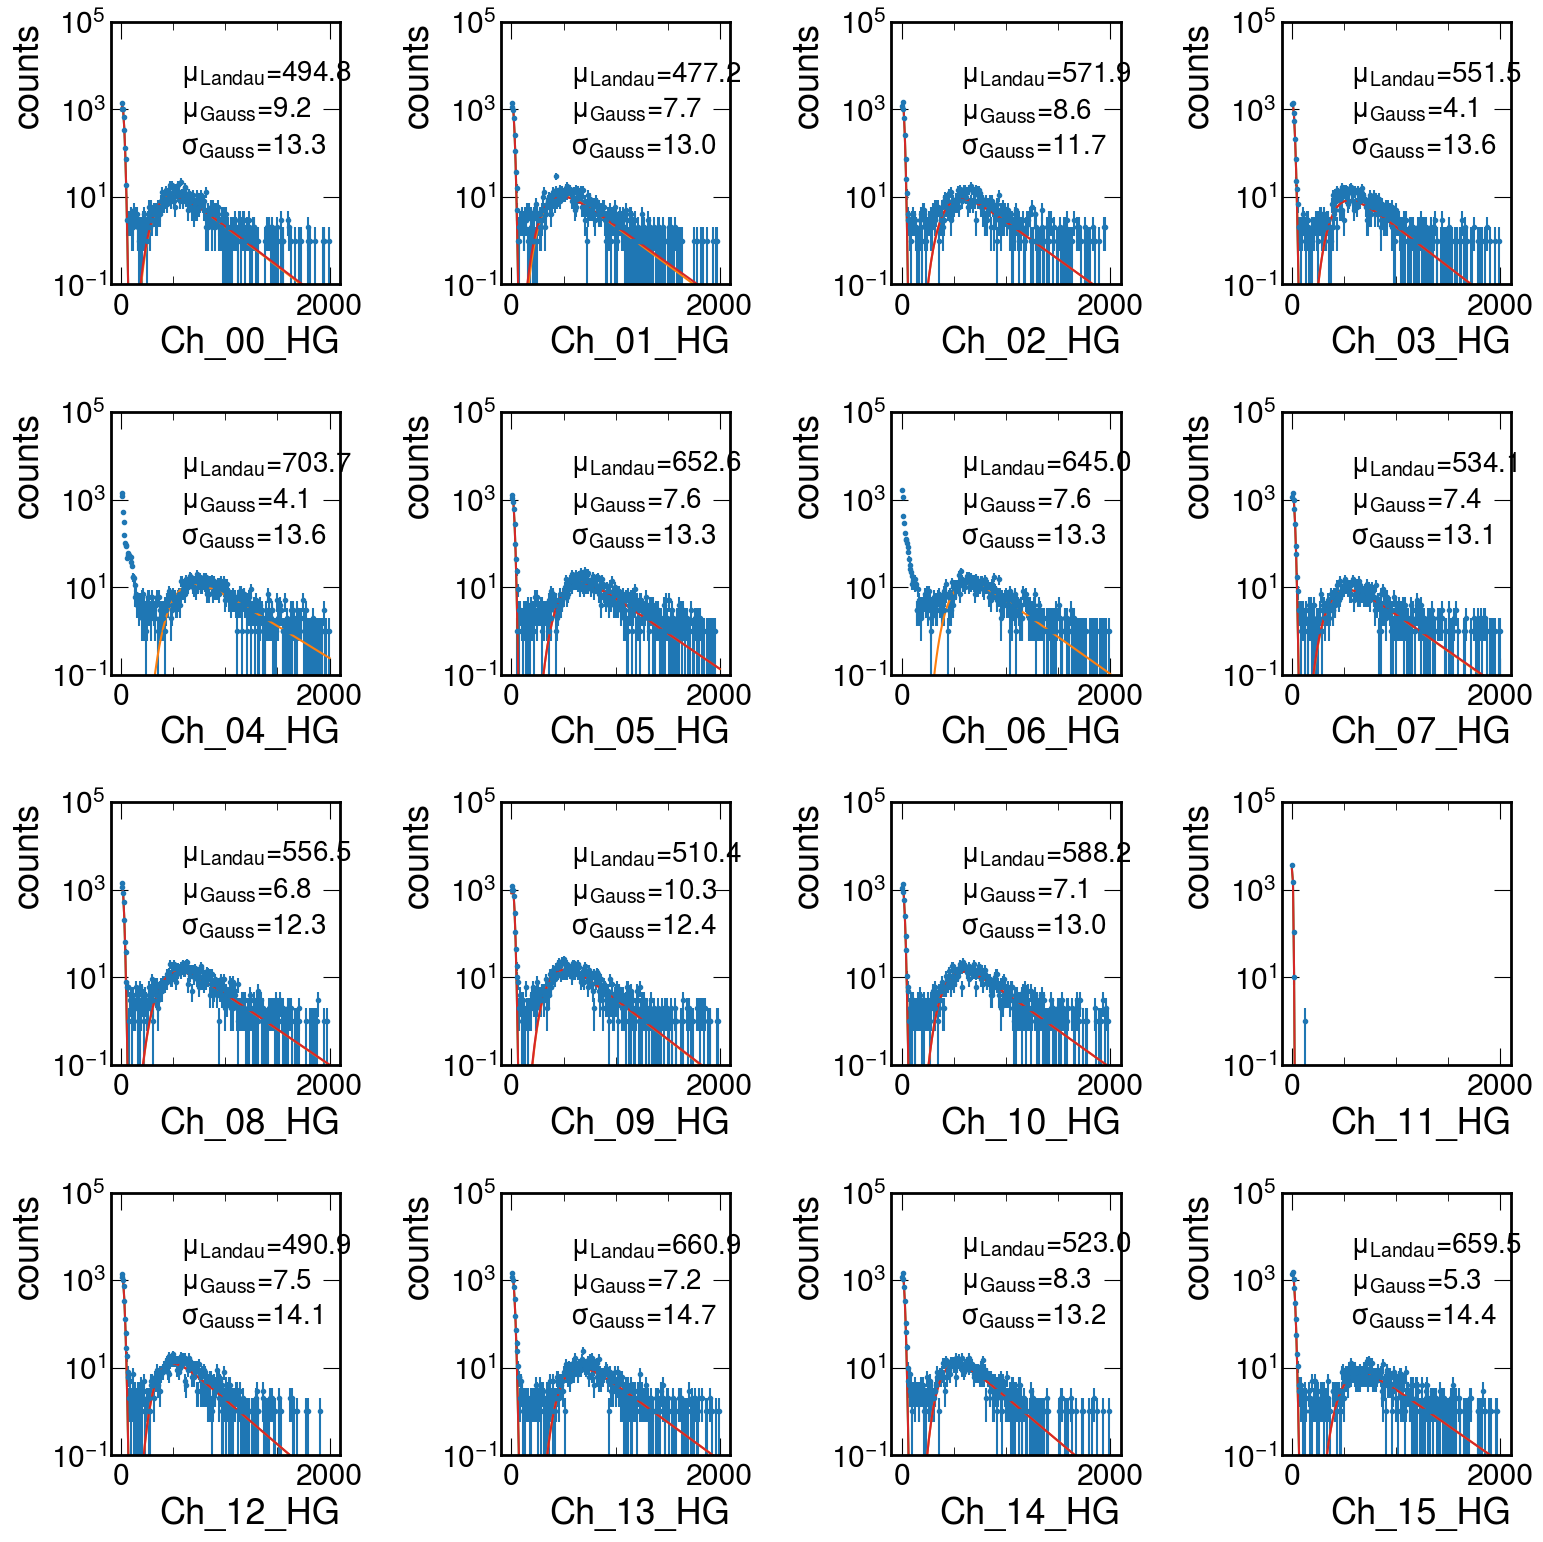

In [272]:
for useMIP in False,:
    for gain in "LG HG".split():
        if not useMIP:
            fig, axs=plt.subplots(4,4, figsize=(16, 16))
        else:
            fig, axs=plt.subplots(1,1, figsize=(16, 16))
        for i in range(len(channels)):

            ch = channels[i]
            if not useMIP:
                plt.sca(axs[i//4][i%4])
            hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=100 if gain== "LG" else 300, 
                                  range=(0,100) if gain == "LG" else (0, 2000))
            xlabel=f"Ch_{ch}_{gain}"
            if useMIP:
                xlabel+='/MIP'
            
            plt.xlabel(xlabel)
            plt.ylabel("counts")

            bin_centers=(x[1:]+x[:-1])/2

            from scipy.optimize import curve_fit
            if gain=="LG":
                start,stop=int(20/(x[1]-x[0])),None
            else :
                start,stop=int(200/(x[1]-x[0])),None
            p0=[1000, 30, 10]

            if gain == "HG":
                plt.yscale("log")
                plt.ylim(0.1, 1e5)
            dhist=np.sqrt(hist)+(hist==0)
            
            # if we're not dividing by the MIP, draw the channels as they are before attempting the fit, 
            # rather than afterwards
            if not useMIP:
                plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)
            
            try:
                coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                     sigma=dhist[start:stop])
                
                if not useMIP:
                    curve = plt.plot(x, Landau(x,*coeff), label=f"Landau")
                from scipy.stats import chi2
                #chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
                #ndof = len(bin_centers[start:stop])-len(coeff)
                #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
                x=np.linspace(0, max(bin_centers), 200)
                mu=coeff[1]

                try:
                    if gain=="LG":
                        start, stop = 0, int(20/(bin_centers[1]-bin_centers[0]))
                    else :
                        start, stop = 0, int(100/(bin_centers[1]-bin_centers[0]))
                    coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], p0=[10000,10,15],
                                             sigma=dhist[start:stop])
                    if not useMIP:
                        curve = plt.plot(x, Gauss(x,*coeff_g), label=f"Gauss")



                    coeff_lg, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                                             sigma=dhist)
                    if not useMIP:
                        curve = plt.plot(x, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")

                    mu=coeff_lg[1]
                    mu_g=coeff_lg[4]
                    sigma_g=abs(coeff_lg[5])
                except :
                    print("warning:  failed Landau+Gauss fit.  using Landau fit only")
                
                scale=1
                if useMIP:
                    scale=1/mu
                    plt.errorbar(bin_centers*scale, hist*len(hist)/sum(hist), np.sqrt(hist)*len(hist)/sum(hist), 
                                 linestyle='', marker='o', markersize=8, fillstyle='none' if i < 10 \
                                else 'full', label=f'Ch_{ch}_{gain}')
                    #curve = plt.plot(x*scale, Landau(x,*coeff), label=f"Landau")
                    #curve = plt.plot(x*scale, Gauss(x,*coeff_g), label=f"Gauss")
                    #curve = plt.plot(x*scale, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")

                #plt.legend(fontsize=12)
                
                if abs(mu*scale) < 1e5:
                    print(mu*scale)
                    if not useMIP:
                        plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu*scale:.1f}\n$\mu_{{\\rm Gauss}}$={mu_g*scale:.1f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g*scale:.1f}", transform=plt.gca().transAxes, fontsize=20)
                
                
                MIP[(ch,gain)]=mu

            except RuntimeError:
                pass
        if useMIP:
            plt.legend()
        plt.tight_layout()
        print(start)
        print(bin_centers[start])
        plt.show()

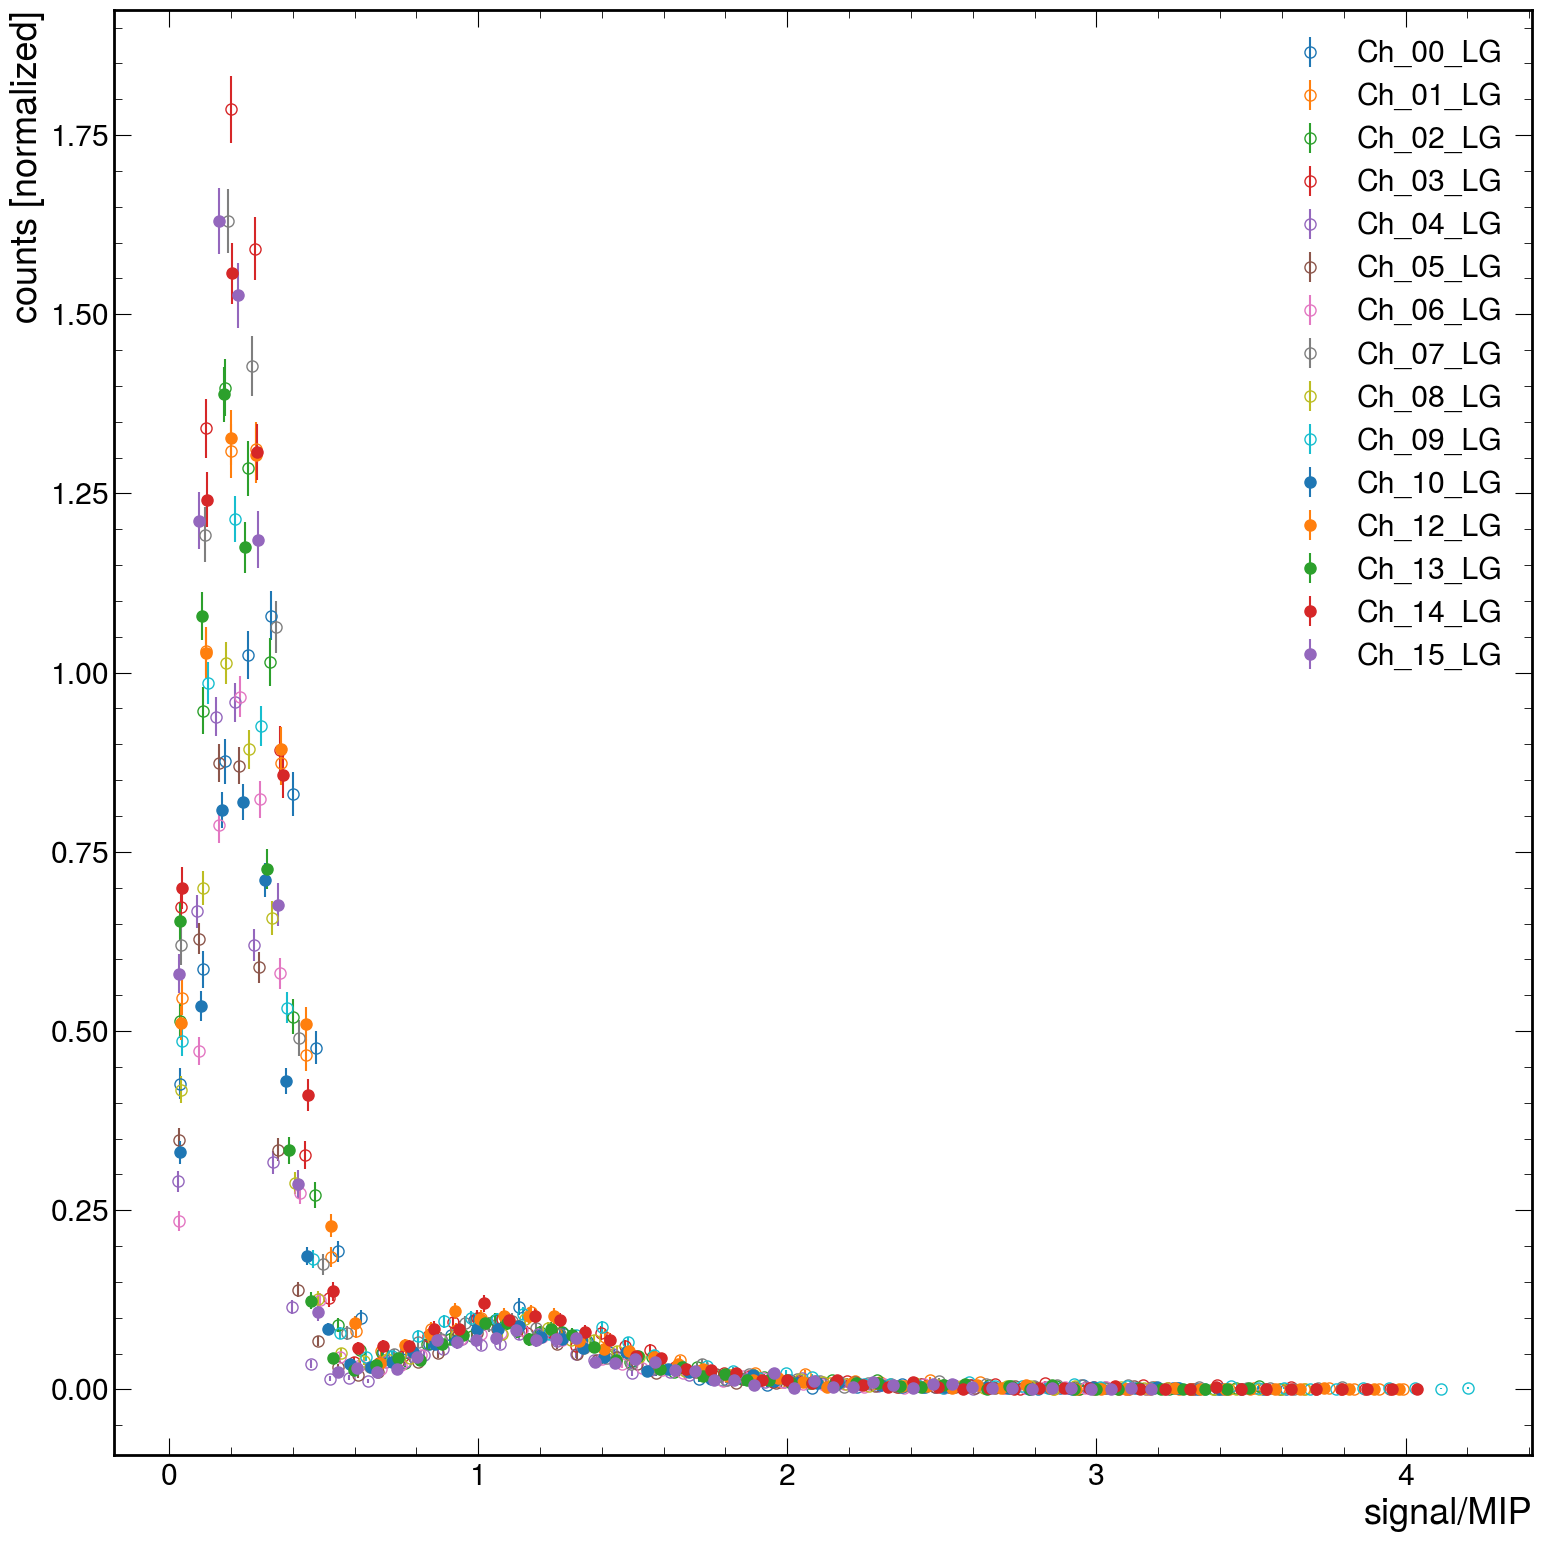

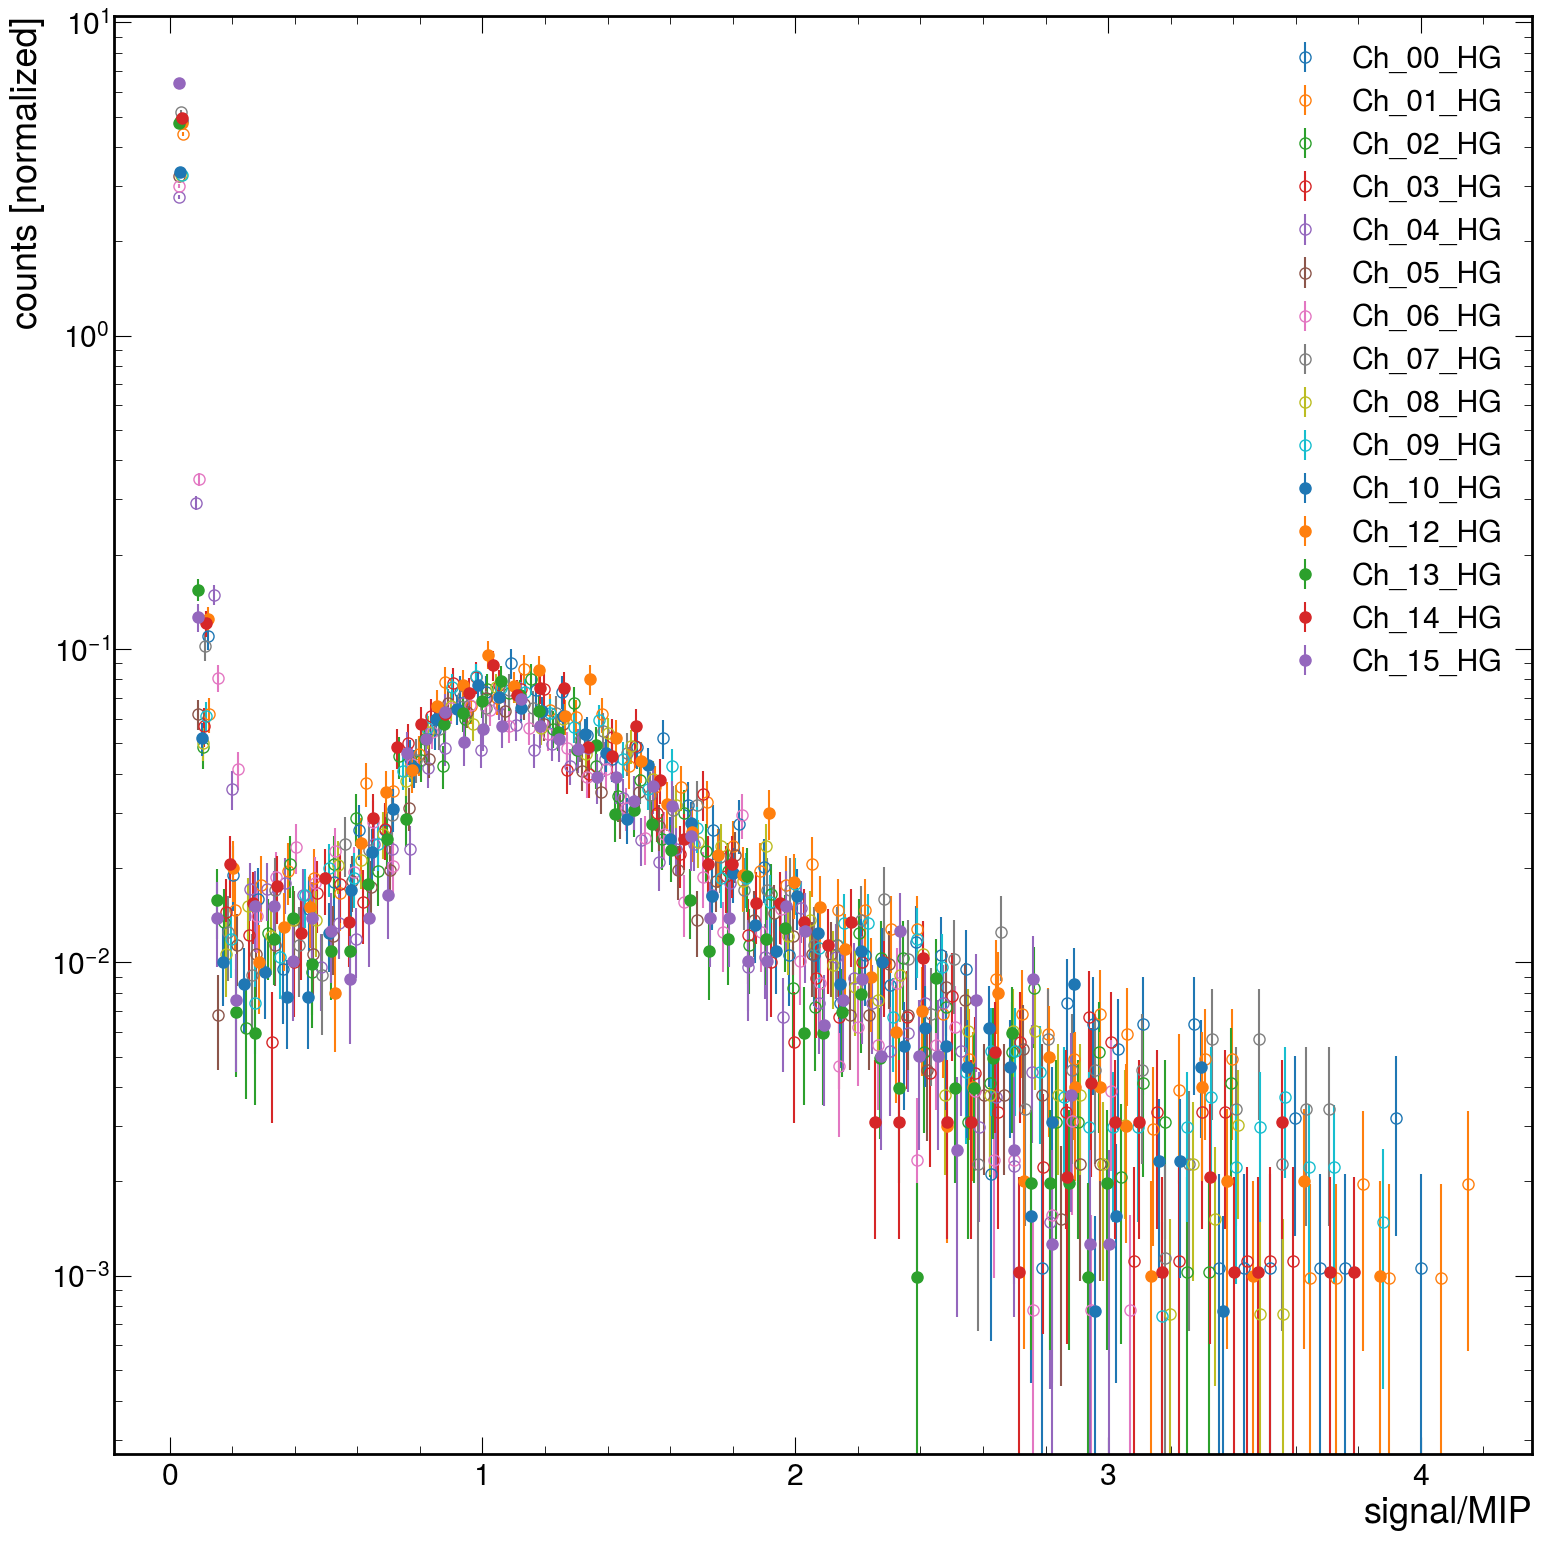

In [274]:
#must run previous cell to get the MIP values before this one
for gain in "LG HG".split():
    fig, axs=plt.subplots(1,1, figsize=(16, 16))
    for i in range(len(channels)):
        
        ch = channels[i]
        
        
        if ch=='11':
            continue
        
        hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=50, 
                              range=(0,100) if gain == "LG" else (0, 2000))
        xlabel=f"signal/MIP"

        plt.xlabel(xlabel)
        plt.ylabel("counts [normalized]")

        bin_centers=(x[1:]+x[:-1])/2

        from scipy.optimize import curve_fit
        if gain=="LG":
            start,stop=int(20/(x[1]-x[0])),None
        else :
            start,stop=int(200/(x[1]-x[0])),None

        if gain == "HG":
            plt.yscale("log")
            #plt.ylim(0.001, 1e3)
        dhist=np.sqrt(hist)+(hist==0)


        scale=1/MIP[(ch, gain)]
        yscale=1/sum(hist[start:stop])
        plt.errorbar(bin_centers*scale, hist*yscale, np.sqrt(hist)*yscale, 
                     linestyle='', marker='o', markersize=8, fillstyle='none' if i < 10 \
                    else 'full', label=f'Ch_{ch}_{gain}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

warning ch  11 is empty


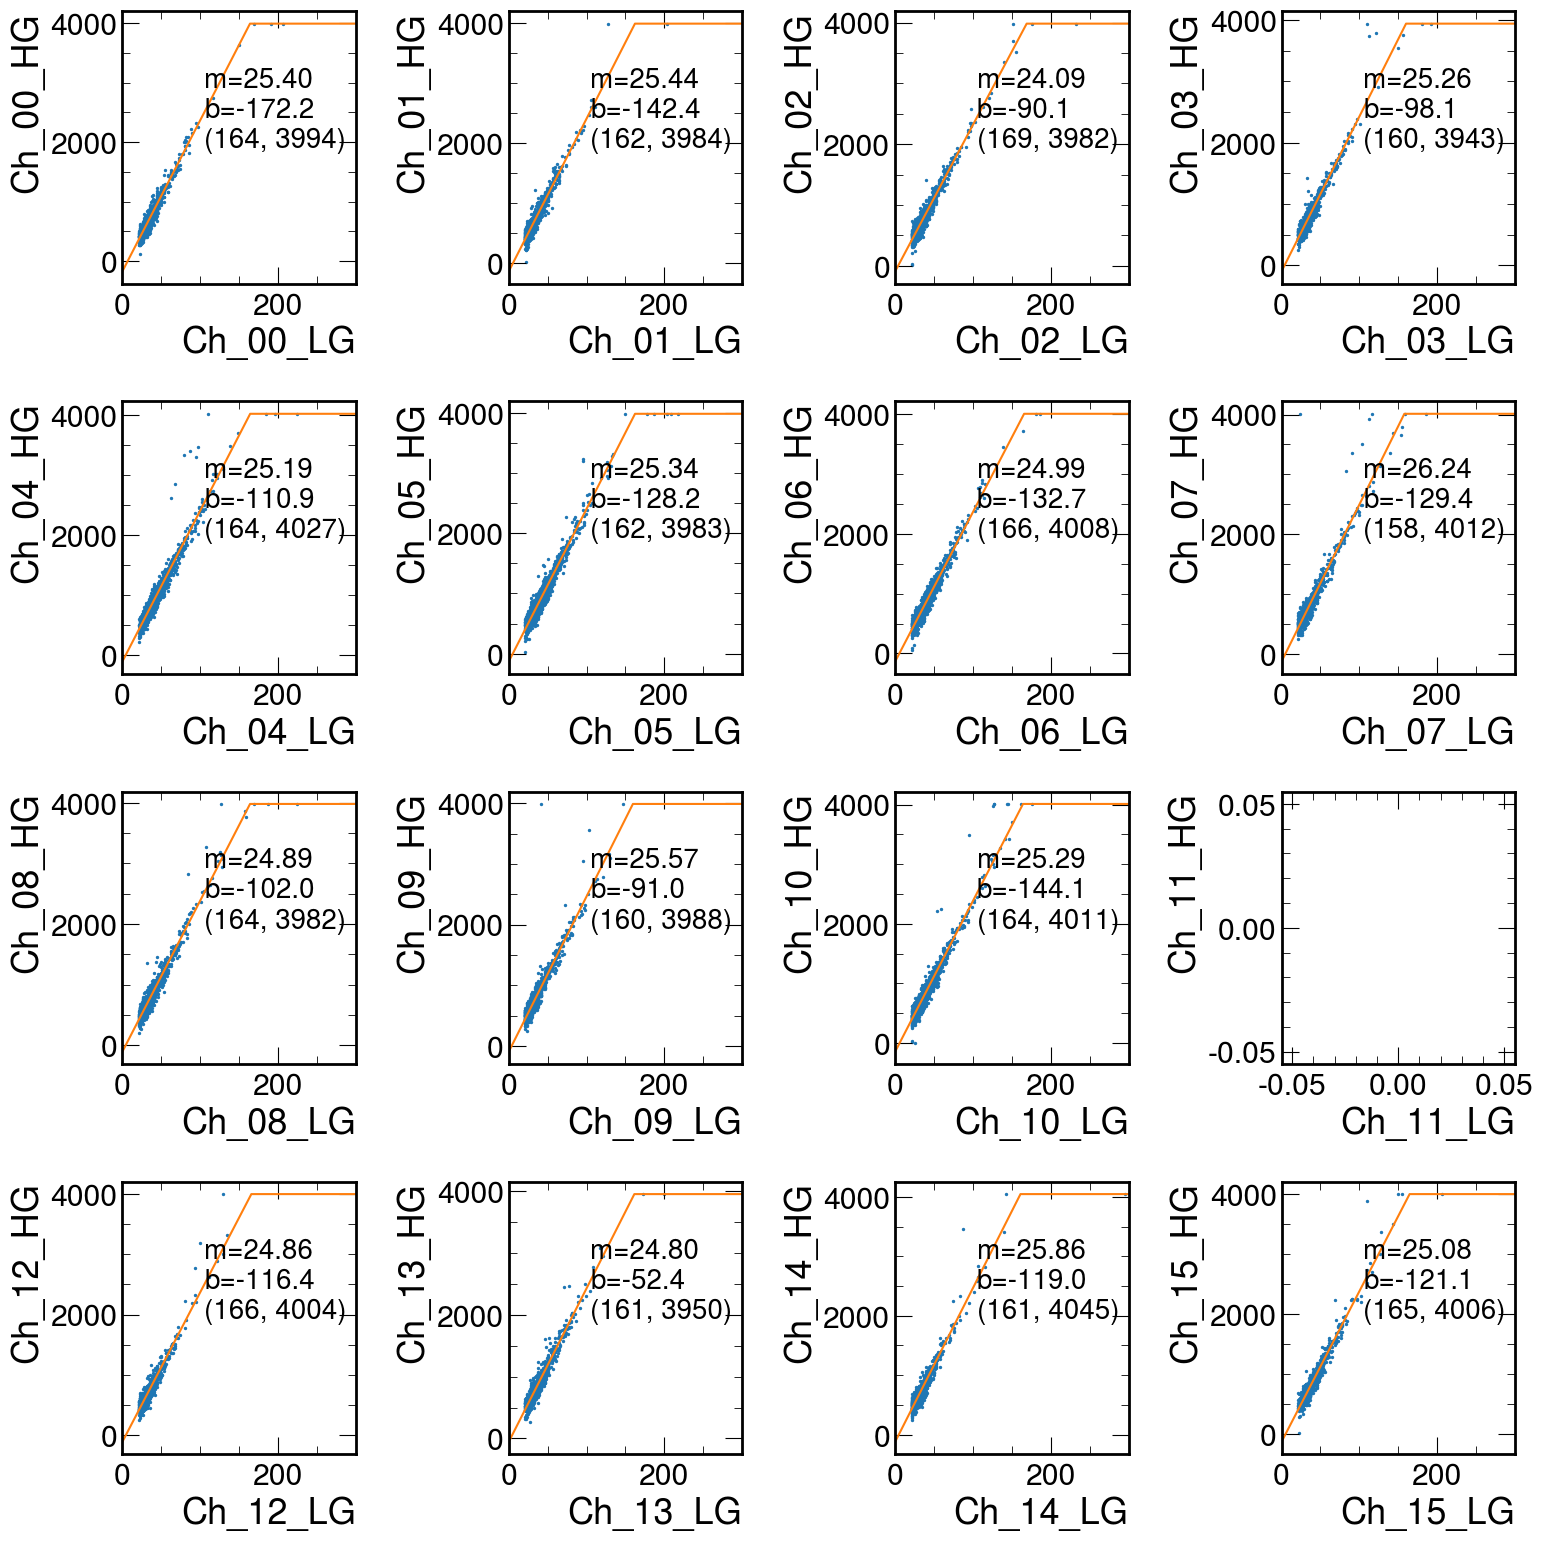

In [246]:
fig, axs=plt.subplots(4,4, figsize=(16, 16))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    
    q= f"Ch_{ch}_LG>20 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    plt.scatter(df.query(q).eval(f"Ch_{ch}_LG"), df.query(q).eval(f"Ch_{ch}_HG"),s=2)
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel(f"Ch_{ch}_HG")
    
    q=f"Ch_{ch}_LG>20 and Ch_{ch}_HG>100 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    x= df.query(q).eval(f"Ch_{ch}_LG") 
    y = df.query(q).eval(f"Ch_{ch}_HG")
    #print(max(y), np.mean(df.query(f"Ch_{ch}_HG>{0.95*max(y)}").eval(f"Ch_{ch}_HG"))/max(y))
    if len(y)==0:
        print("warning ch ", ch, "is empty")
        continue
    q= f"Ch_{ch}_HG<{max(y)} and Ch_{ch}_LG>20 and Ch_{ch}_HG>100 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    xf= df.query(q).eval(f"Ch_{ch}_LG")
    yf= df.query(q).eval(f"Ch_{ch}_HG")
    m=(np.sum(xf*yf)*len(xf)-np.sum(xf)*np.sum(yf))/(np.sum(xf*xf)*len(xf)-np.sum(xf)*np.sum(xf))
    b = (sum(yf)-m*sum(xf))/len(xf)
    xelbow=(max(y)-b)/m
    yelbow=max(y)
    plt.plot([0, xelbow, max(df.eval(f"Ch_{ch}_LG"))], [b, yelbow, yelbow], linestyle='-', color='tab:orange')
    plt.text(0.35, 0.5, f"m={m:.2f}\nb={b:.1f}\n({xelbow:.0f}, {yelbow:.0f})", transform=plt.gca().transAxes, fontsize=20)
    plt.xlim(0, 300)
plt.tight_layout()

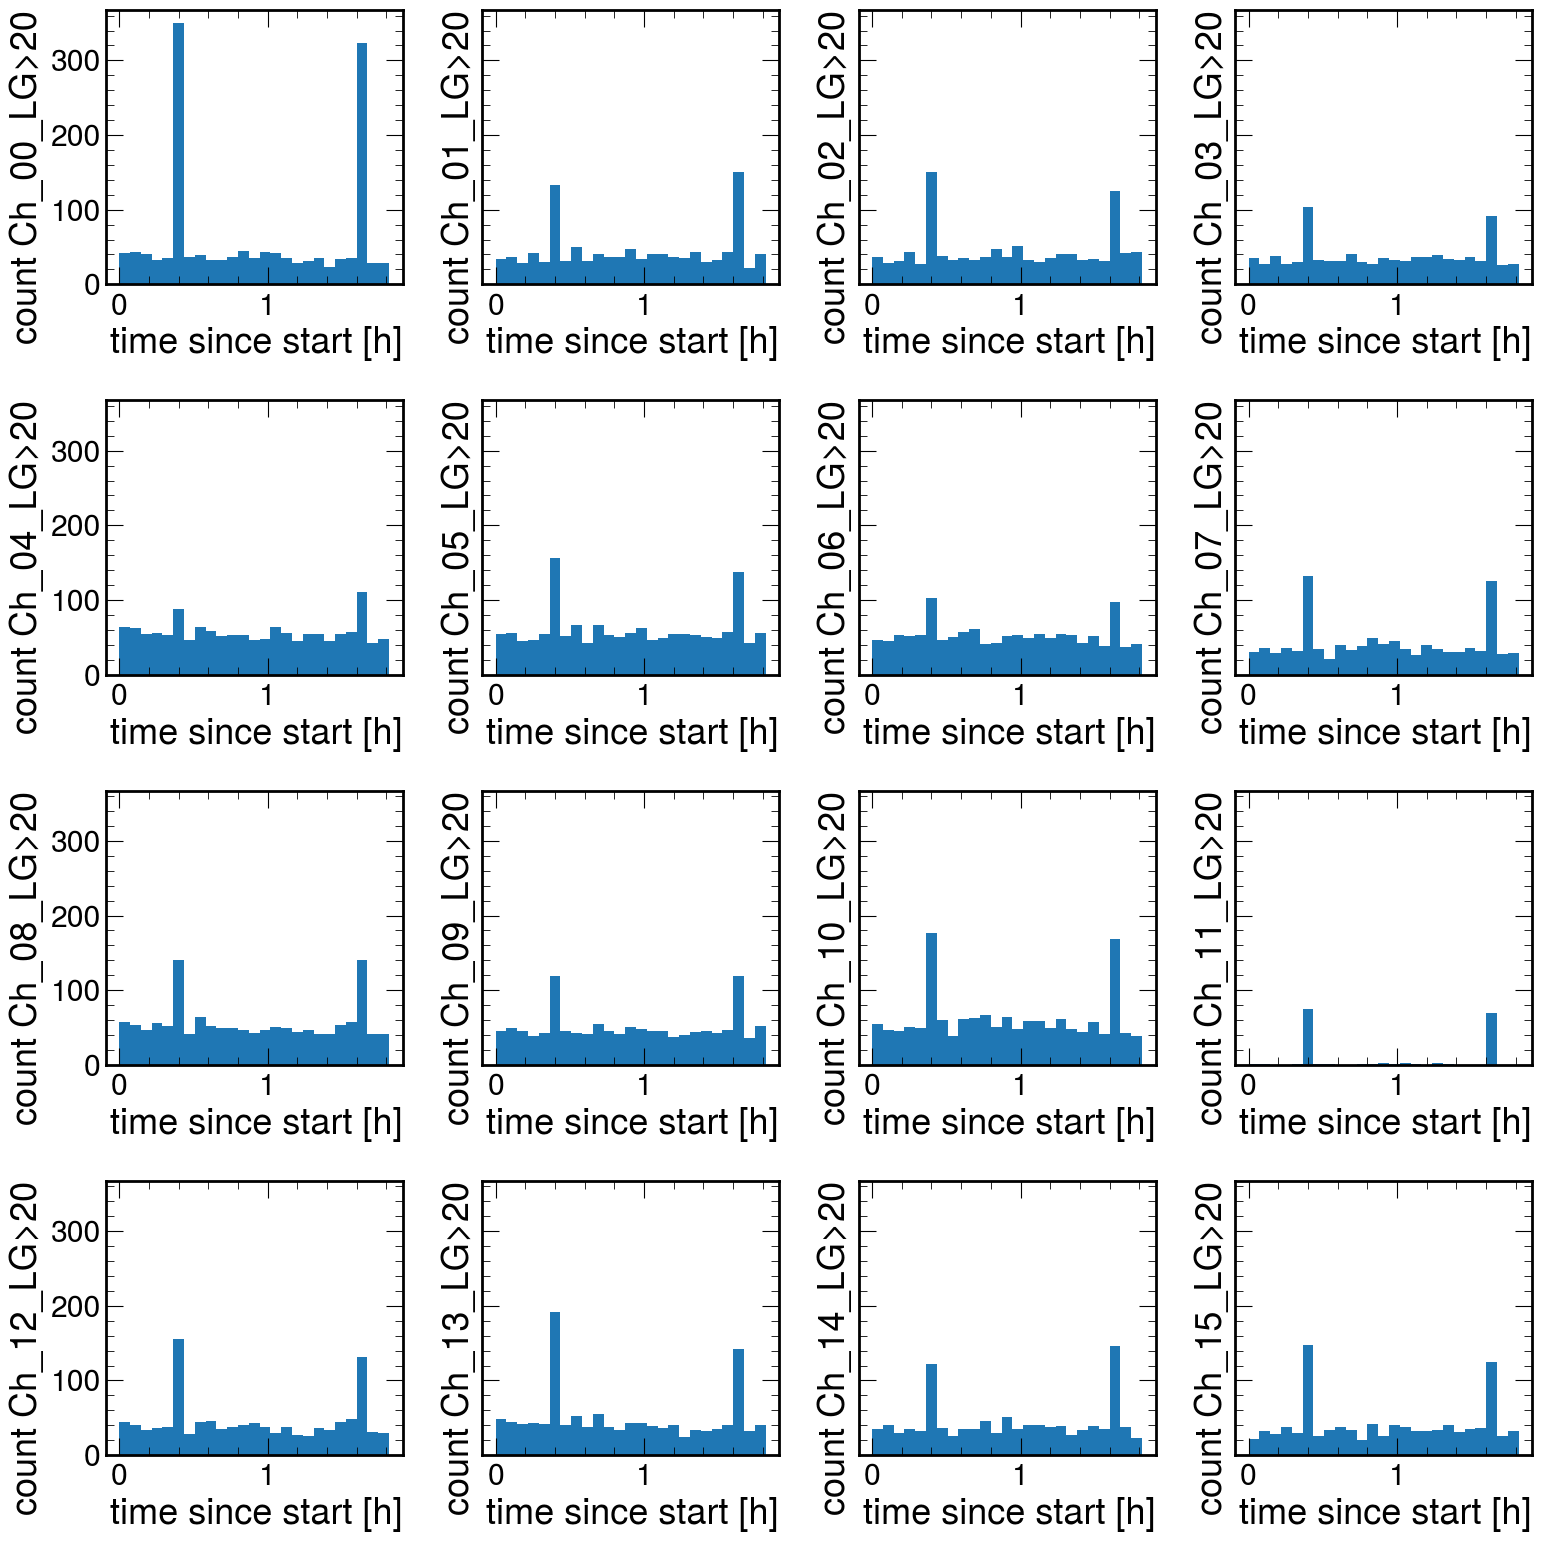

In [247]:
fig, axs=plt.subplots(4,4, figsize=(16, 16),sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    plt.hist(df.query(f"Ch_{ch}_LG>20").eval(f"timestamp/3.6e9"), bins=25, range=(0,max(df.timestamp)/3.6e9))
    plt.xlabel(f"time since start [h]")
    plt.ylabel(f"count Ch_{ch}_LG>20")
plt.tight_layout()

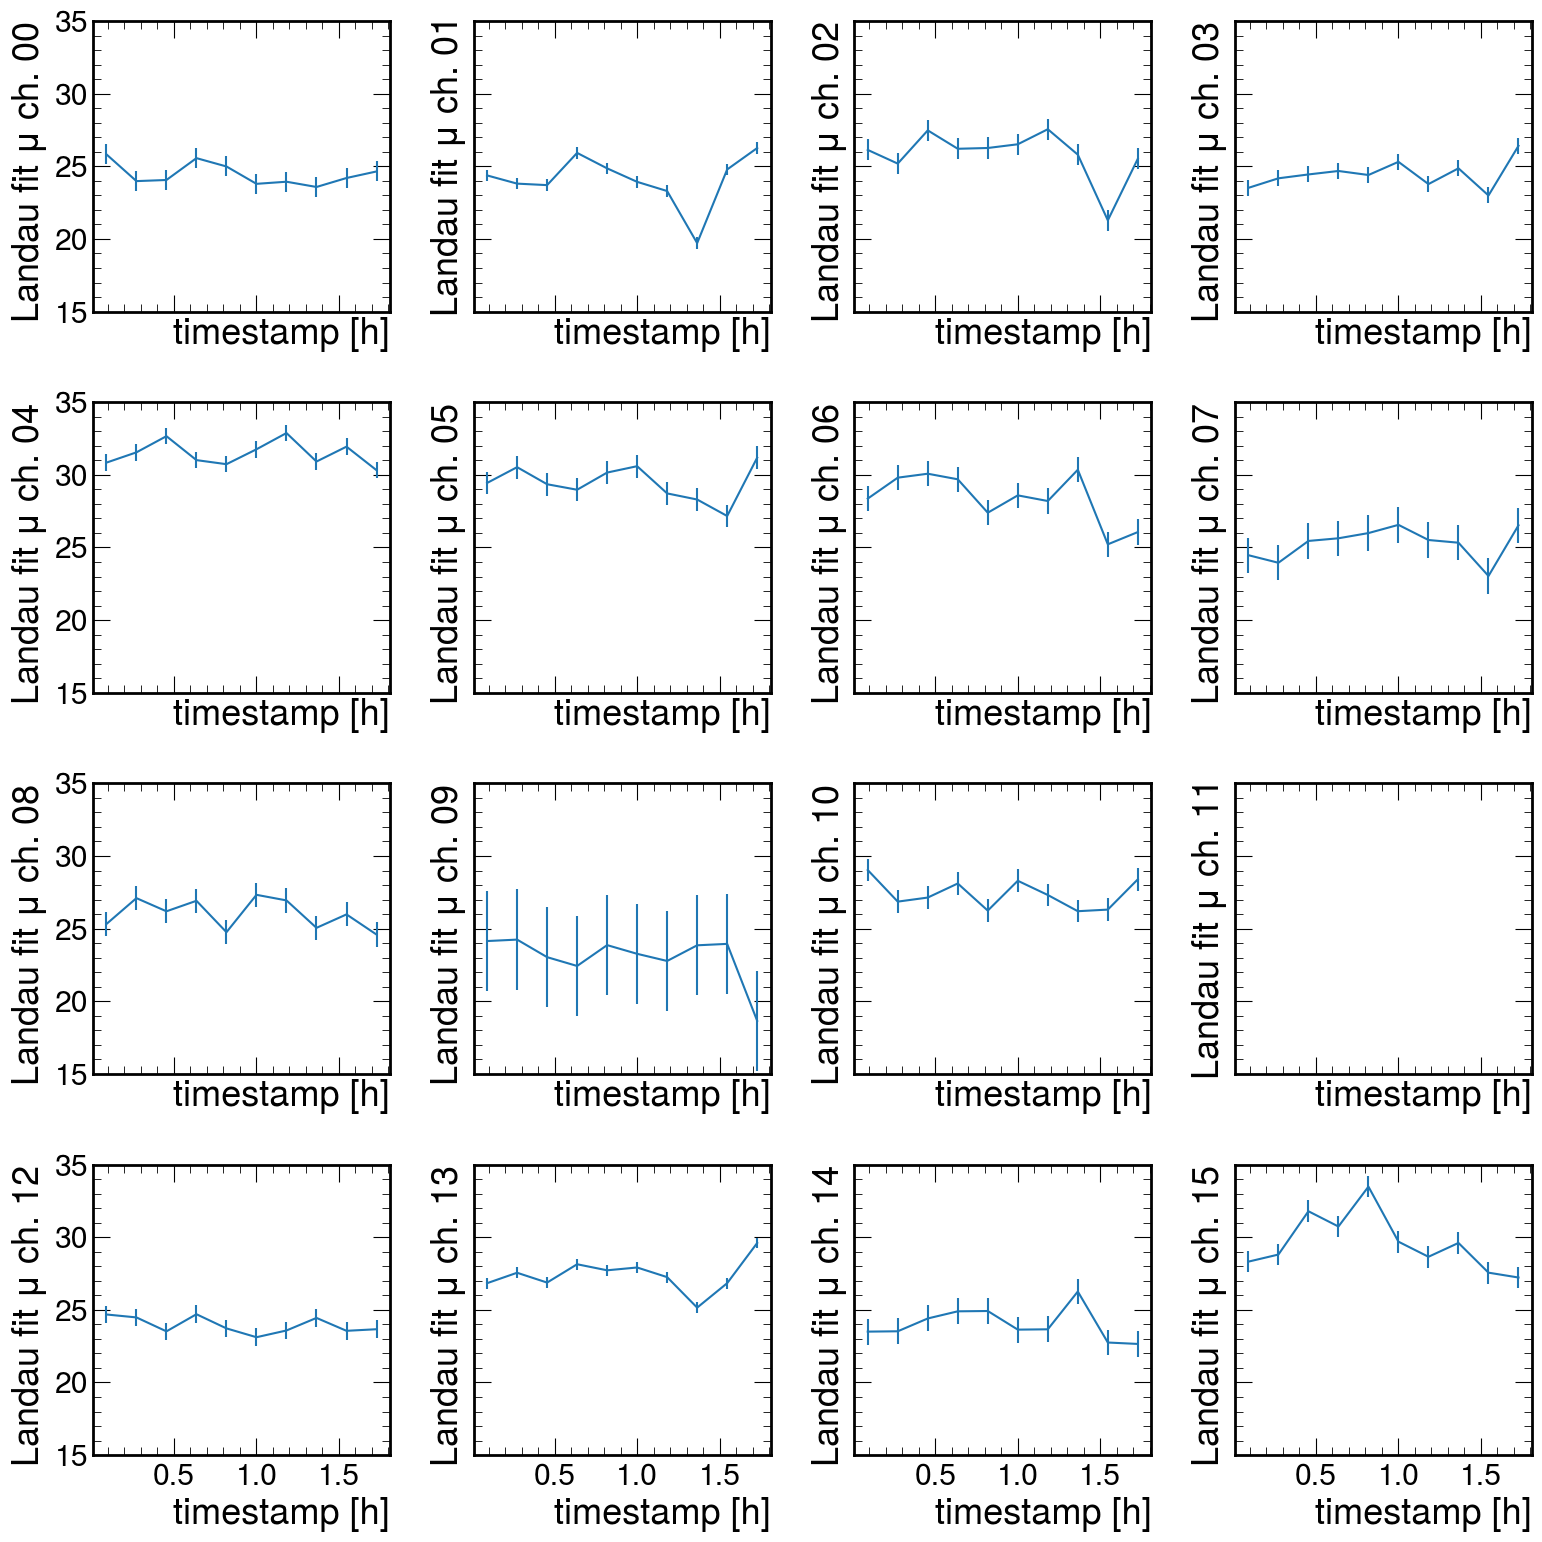

In [248]:
fig, axs=plt.subplots(4,4, figsize=(16, 16),sharex='all', sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    slices = np.linspace(min(df.timestamp), max(df.timestamp), 11)
    mus=[]
    dmus=[]
    centers=[]
    for j in range(len(slices)-1):
        try:
            hist,x,= np.histogram(df.query(f"timestamp>{slices[j]} and timestamp<{slices[j+1]}")\
                                  .eval(f"Ch_{ch}_LG"), bins=26, range=(0,200))


            bin_centers=(x[1:]+x[:-1])/2

            from scipy.optimize import curve_fit
            start,stop=int(20/(x[1]-x[0])),None
            p0=[1000, 30, 10]

            #plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')

            dhist=np.sqrt(hist[start:stop])+(hist[start:stop]==0)
            #print(i,j)
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                     sigma=dhist)
            from scipy.stats import chi2
            chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist**2)
            ndof = len(bin_centers[start:stop])-len(coeff)
            #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, 140, 280)
            mu=coeff[1]
            
            dmu=np.sqrt(var_matrix[1][1])
            if abs(mu)>1000 or abs(dmu)>1000 or var_matrix[1][1]<0 :
                continue
            mus.append(mu)
            dmus.append(dmu)
            centers.append((slices[j]+slices[j+1])/2)
        except RuntimeError:
            pass
    plt.ylim(15, 35)
    plt.errorbar(np.array(centers)/(3.6e9), mus, dmu)
    plt.xlabel(f"timestamp [h]")
    plt.ylabel(f"Landau fit $\mu$ ch. {ch}")
    
plt.tight_layout()

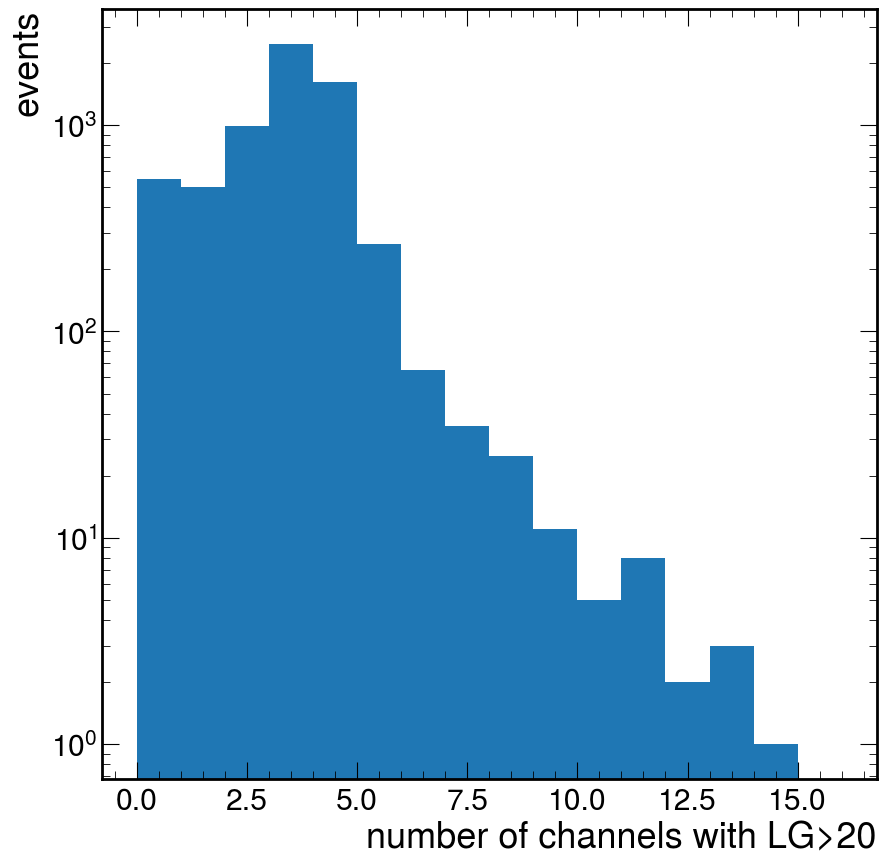

In [250]:
a="0"
for ch in channels:
    a+=f"+1*(Ch_{ch}_LG>20)"
plt.hist(df.eval(a),bins=16, range=(0,16))
plt.xlabel("number of channels with LG>20")
plt.ylabel("events")
plt.yscale('log')
plt.show()

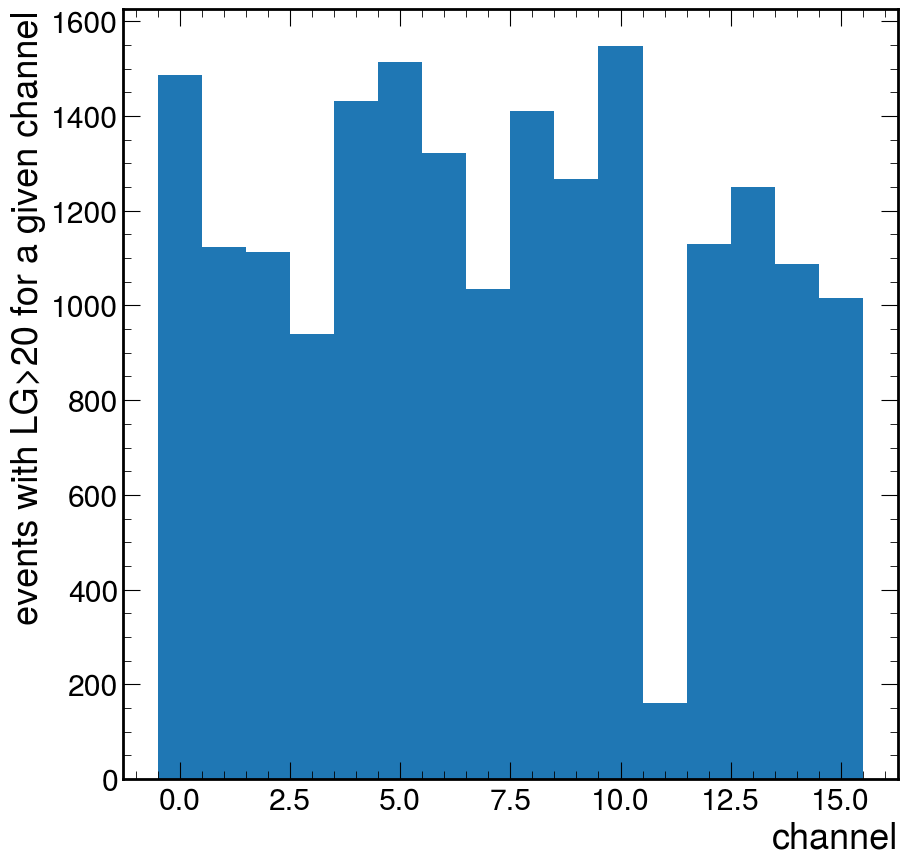

In [251]:
x=[]
y=[]
for ch in channels:
    x.append(int(ch))
    y.append(len(df.query(f"Ch_{ch}_LG>20")))
plt.bar(x,y, 1)
plt.xlabel("channel")
plt.ylabel("events with LG>20 for a given channel")
#plt.yscale('log')
plt.show()

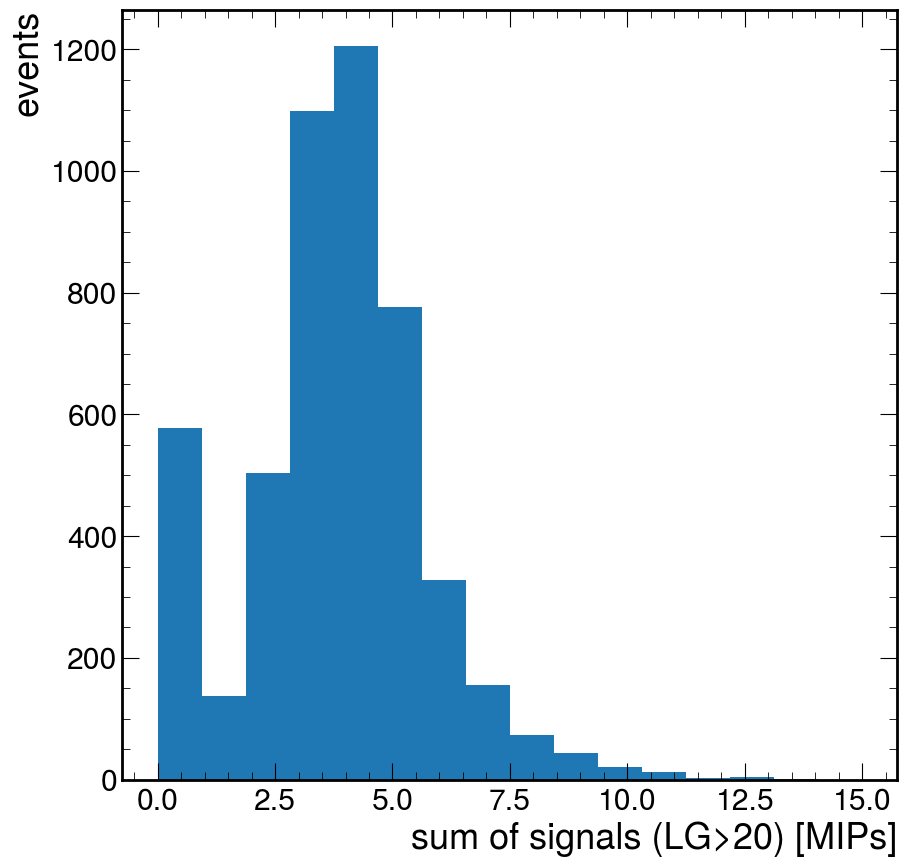

In [252]:
a="0"
for ch in channels:
    if (ch,'LG') in MIP:
        a+=f"+Ch_{ch}_LG*(Ch_{ch}_LG>20)/{MIP[(ch,'LG')]}"
plt.hist(df.eval(a),bins=16, range=(0,15))
plt.xlabel("sum of signals (LG>20) [MIPs]")
plt.ylabel("events")
#plt.yscale('log')
plt.show()

(0.0, 1.0)

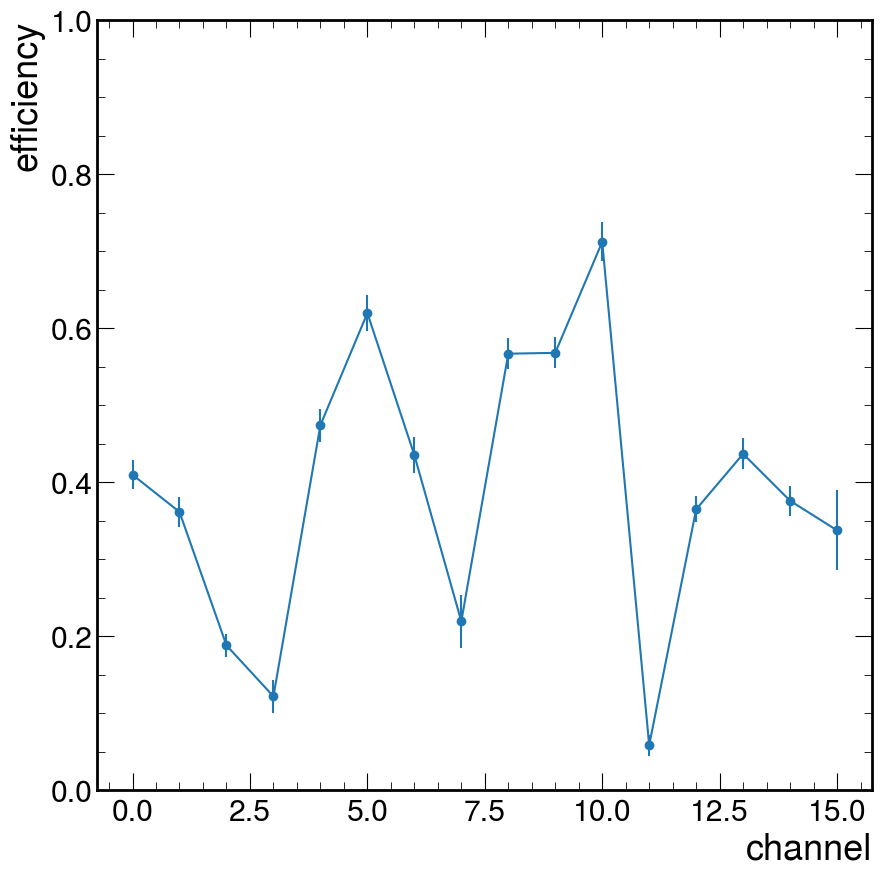

In [260]:
#efficiency plot:
th1=30
th2=20

eff=[]
deff=[]
x=[]

for ch in channels:
    q = "2<=0"#start with dummy condition
    for a in channels:
        if a !=ch and int(ch)%4==int(a)%4:
            q+=f"+1*(Ch_{a}_LG>{th1})"
    denom = len(df.query(q))
    num = len(df.query(q).query(f"Ch_{ch}_LG>{th2}"))
    eff.append(num/denom)
    deff.append(np.sqrt(num*(denom-num)/denom**3))
    x.append(int(ch))
plt.errorbar(x, eff, deff, marker='o')
plt.xlabel('channel')
plt.ylabel('efficiency')
plt.ylim(0,1)